#### a feature:
- the league position of the teams in the previous season
- maybe a current league position of bothe teams at the moment when the match is happening

#### outlier removals to be done
#### more algorithms and more corresponding search spaces


In [1]:
import warnings
%load_ext autoreload
%autoreload 2
warnings.simplefilter('ignore')

# "chr=conceded-home-rolling"
# "car=conceded-away-rolling"
# "hr=home-rolling"
# "ar=away-rolling"

In [2]:
from preprocess import pack
import optimization
from features import Features, feature_selection


import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from collections import OrderedDict
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score


In [3]:
def encoder(data,features):
    from sklearn.preprocessing import OrdinalEncoder
    oe=OrdinalEncoder()
    data[features]=oe.fit_transform(data[features])
    return data

In [4]:
feat = Features(**pack)
data = feat.execute()
container = feature_selection(data)
trainx = container.trainx
trainy = container.trainy
trainx=encoder(trainx,['hometeam','awayteam','referee','season'])

# trainx,valx,trainy,valy=train_test_split(trainx,trainy)
trainx.reset_index(inplace=True,drop=True)
# valx.reset_index(inplace=True,drop=True)
trainy.reset_index(inplace=True,drop=True)
# valy.reset_index(inplace=True,drop=True)

In [13]:
trainx.columns

Index(['season', 'referee', 'hometeam', 'awayteam', 'ftg_hr', 'htg_hr', 's_hr',
       'st_hr', 'c_hr', 'f_hr', 'y_hr', 'r_hr', 'p_hr', 'hp_hr', 'ftg_ar',
       'htg_ar', 's_ar', 'st_ar', 'c_ar', 'f_ar', 'y_ar', 'r_ar', 'p_ar',
       'hp_ar', 'ftg_chr', 'htg_chr', 's_chr', 'st_chr', 'c_chr', 'f_chr',
       'y_chr', 'r_chr', 'p_chr', 'hp_chr', 'ftg_car', 'htg_car', 's_car',
       'st_car', 'c_car', 'f_car', 'y_car', 'r_car', 'p_car', 'hp_car', 'day'],
      dtype='object')

<AxesSubplot:xlabel='y_car'>

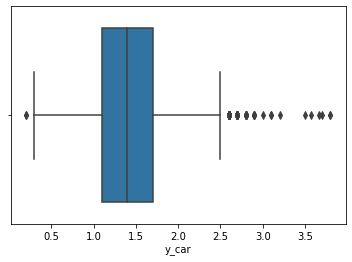

In [15]:
sns.boxplot(trainx['y_car'])

In [28]:
best_params = optimization.optimizer(trainx,trainy, 'XGBoost_classif')

XGBoost_classif took 3925.00 seconds,  candidates checked: 120, best CV score: 0.597 ± 0.001
Best parameters:
OrderedDict([('booster', 'gbtree'),
             ('colsample_bytree', 0.6302194630442275),
             ('learning_rate', 0.01),
             ('max_depth', 1),
             ('max_leaves', 49),
             ('n_estimators', 500),
             ('reg_lambda', 1e-09),
             ('sampling_method', 'uniform'),
             ('subsample', 0.6912252213398504)])


XGBoost_classif took 923.61 seconds,  candidates checked: 120, best CV score: 0.592 ± 0.003
Best parameters:
OrderedDict([('colsample_bytree', 1.0),
             ('learning_rate', 0.01),
             ('max_depth', 4),
             ('n_estimators', 257),
             ('reg_lambda', 22.485977903954552),
             ('subsample', 0.5325852461953129)])

In [ ]:
# better model- in some aspects


# XGBoost_classif took 3925.00 seconds,  candidates checked: 120, best CV score: 0.597 ± 0.001
# Best parameters:
# OrderedDict([('booster', 'gbtree'),
#              ('colsample_bytree', 0.6302194630442275),
#              ('learning_rate', 0.01),
#              ('max_depth', 1),
#              ('max_leaves', 49),
#              ('n_estimators', 500),
#              ('reg_lambda', 1e-09),
#              ('sampling_method', 'uniform'),
#              ('subsample', 0.6912252213398504)])


In [96]:
# best_params['reg_lambda']+=100
# best_params['max_depth']+=5

In [41]:

# best_params = OrderedDict([('colsample_bytree', 1.0),
#                            ('learning_rate', 0.14006304478391782),
#                            ('max_depth', 10),
#                            ('n_estimators', 50),
#                            ('subsample', 1.0)])

    # xgb_param = model.get_xgb_params()
    # xgb_param['num_class'] = 3
    # cvresult = xgb.cv(xgb_param, ...)


model = XGBClassifier(random_state=0, tree_method='hist',objective='multi:softprob',
                      eval_metric=accuracy_score, verbosity=0, num_class=3, grow_policy='lossguide', **best_params)


def train(trainx,trainy,model):
    folds = 10
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)
    train_acc, val_acc = [], []

    for k, (train_idx, val_idx) in enumerate(skf.split(trainx, trainy)):
        t_x = trainx.iloc[train_idx].values
        t_y = trainy.iloc[train_idx].values
        v_x = trainx.iloc[val_idx].values
        v_y = trainy.iloc[val_idx].values
        
        model.fit(t_x,t_y)
        train_preds = model.predict(t_x)
        val_preds = model.predict(v_x)
        
        acc_t = accuracy_score(y_true=t_y, y_pred=train_preds)
        acc_v = accuracy_score(y_true=v_y, y_pred=val_preds)
        
        train_acc.append(acc_t)
        val_acc.append(acc_v)
        
    return np.mean(train_acc), np.mean(val_acc)


In [42]:
# import features
# best = features.auto_best_features(trainx, trainy, n_features=30)

In [43]:
a,b=train(trainx,trainy,model)
a,b

In [45]:
model.fit(trainx,trainy)
v_preds=model.predict(valx)

In [46]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(v_preds,valy))
print(f1_score(v_preds,valy,average='weighted'))
print(recall_score(v_preds,valy,average='weighted'))
print(precision_score(v_preds,valy,average='weighted'))
accuracy_score(v_preds,valy)

[[  0   0   0]
 [178 400 119]
 [327 208 841]]
0.6840553867700249
0.5986493005306319
0.8026946285153309


0.5986493005306319

In [47]:
model.fit(trainx,trainy)
t_preds=model.predict(trainx)
v_preds=model.predict(valx)

In [48]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(t_preds,trainy))
print(f1_score(t_preds,trainy,average='weighted'))
print(recall_score(t_preds,trainy,average='weighted'))
print(precision_score(t_preds,trainy,average='weighted'))
accuracy_score(t_preds,trainy)

[[   2    1    0]
 [ 716 1629  499]
 [1351  787 3304]]
0.6817433311845511
0.5953673543250091
0.8016327489564088


0.5953673543250091

In [49]:
print(confusion_matrix(v_preds,valy))
print(f1_score(v_preds,valy,average='weighted'))
print(recall_score(v_preds,valy,average='weighted'))
print(precision_score(v_preds,valy,average='weighted'))
accuracy_score(v_preds,valy)

[[  0   0   0]
 [178 400 119]
 [327 208 841]]
0.6840553867700249
0.5986493005306319
0.8026946285153309


0.5986493005306319

In [ ]:
# mi = features.mutual_information(best, trainy)
# features.plotmi(mi)

In [39]:
# train_acc,val_acc=train(best, trainy)
# train_acc,val_acc



In [1]:
import torch
a=[torch.tensor([[1,2,3]]),torch.tensor([[1,2,3]]),torch.tensor([[1,2,3]])]
b=torch.stack(a,dim=1)


: 

: 

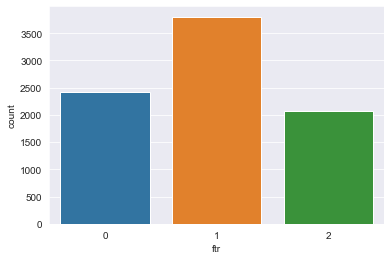

In [80]:
sns.countplot(trainy);

In [82]:
train(trainx,trainy)

(0.9823862979360414, 0.5702755779327867)

In [ ]:
# find the optimal parameters and by training and validating multiple times -the training and validation can be daone in loop or in single sert

In [16]:
import torch
from torch.utils.data import DataLoader

class Loader:
    def __init__(self,x,y):
        self.trainx=x.values
        self.trainy=y.values
    def __len__(self):
        return len(self.trainx)
    def __getitem__(self,idx):
        return {'x':self.trainx[idx],'y':self.trainy[idx]}

In [55]:
epochs=10
t_x,v_x,t_y,v_y=train_test_split(trainx,trainy,test_size=0.2)
trainloader=DataLoader(Loader(t_x,t_y),batch_size=64)
val_loader=DataLoader(Loader(v_x,v_y),batch_size=8)
best_params = OrderedDict([('colsample_bytree', 1.0),
                           ('learning_rate', 0.14006304478391782),
                           ('max_depth', 10),
                           ('n_estimators', 50),
                           ('subsample', 1.0)])
model = XGBClassifier(random_state=0, booster='gbtree', tree_method='hist', eval_metric='mlogloss', objective='multi:softprob' ,verbosity=0, **best_params)
model.fit(t_x,t_y)